### Part I: Train a machine learning model to emulate the L63 model

In [1]:
### Import packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
from tqdm import tqdm

### Functions
def normalise(x, x_mean,x_std):
    return(x-x_mean)/x_std

def denormalise(x_norm,x_mean,x_std):
    return x_norm*x_std+x_mean

def F(x, sigma=10, beta=8/3, rho=28): # true Lorenz 63 dynamics
    dx = sigma * (x[1] - x[0])
    dy = x[0] * (rho - x[2]) - x[1]
    dz = x[0] * x[1] - beta * x[2]
    return np.array([dx, dy, dz])

### Variable declarations
Nx = 3 # number of model variables
# initial conditions
x0_ML, y0_ML, z0_ML = 4.0, 10.0, 1.0; initial_conditions = np.array([x0_ML, y0_ML, z0_ML])
Dt = 10 # hch: Katy, what is the difference between Dt and Nt_shift defined later?
dt = 0.01  # time step for true L63 model
Ns = 5000 # number of samples
Nt_shift = 10 # number of integration time steps between samples
Nt_spinup = 10000 # hch: Katy, this is currently not used, why?
Nt_truth = Ns*Nt_shift+Dt
r = 1 # std of noise to be added to true model trajectory later on

### Generate a model trajectory with the true L63 dynamics
x_truth = np.empty((Nt_truth,Nx))
x_truth[0] = initial_conditions
x_ML = initial_conditions.copy()  # initialize x with initial conditions
with tqdm(total=Nt_truth - 1, desc='L63 trajectory') as progress:
    for i in range(1,Nt_truth):  # note: (1, Nt_truth) because the initial condition is already added
        x_ML += dt * F(x_ML)
        x_truth[i] = x_ML   # append the new state to the trajectory
        progress.set_postfix_str(x_ML, refresh=False)
        progress.update()
# hch: Katy, you don't seem to discard model spinup here, why?

L63 trajectory: 100%|██████████| 50009/50009 [00:01<00:00, 35686.48it/s, [ 6.75935591 10.96555287 16.34332295]]   


In [2]:
### Perturb to avoid overfitting
x_perturb = x_truth + np.random.normal(loc=0, scale=r, size=(Nt_truth, Nx))

### Prepare (x,y) pairs for supervised learning
x_raw = x_perturb[:Nt_truth-Dt:Nt_shift] # Nt_shift is step size
y_raw = x_perturb[Dt:Nt_truth:Nt_shift]

### Normalize data
x_mean = x_raw.mean(axis=0)
y_mean = y_raw.mean(axis=0)
x_std = x_raw.std(axis=0)
y_std = y_raw.std(axis=0)
x_raw_norm = normalise(x_raw,x_mean,x_std)
y_raw_norm = normalise(y_raw,y_mean,y_std)

### Split into training and validation sets
# with 10% of the data being reserved for validation
#index_train = np.array([i for i in range(Ns) if i%10 + 1])
#index_valid = np.array([i for i in range(Ns) if not i%10])
#Use first 5000 as training and next 1000 for validation
#index_train = np.arange(3999)  # Create an array of indexes from 0 to 3999 (inclusive)
#index_valid = np.arange(4000, 5000) 
index_train = np.array([i for i in range(Ns) if i<4000])
index_valid = np.array([i for i in range(Ns) if i>=4000 and i <5000])
x_train_norm = x_raw_norm[index_train]
y_train_norm = y_raw_norm[index_train]
x_valid_norm = x_raw_norm[index_valid]
y_valid_norm = y_raw_norm[index_valid]

### Define ML model
initialiser = tf.keras.initializers.GlorotNormal(seed = 34)
# early stopping 
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,           # Print messages about early stopping
    restore_best_weights=True  # Restore the weights from the epoch with the best value of the monitored quantity
)
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(3,)))
model.add(tf.keras.layers.Dense(20, activation='relu', kernel_initializer=initialiser))
model.add(tf.keras.layers.Dense(10, activation='relu', kernel_initializer=initialiser))
model.add(tf.keras.layers.Dense(3, kernel_initializer=initialiser))
model.compile(optimizer='adam', loss='mse')

### Train ML model
history = model.fit(
    x_train_norm, y_train_norm,
    epochs=60,
    batch_size=256,
    validation_data=(x_valid_norm, y_valid_norm),
    callbacks=[early_stopping_callback]
    # can put where to save in early callback
)

Epoch 1/60
 1/16 [>.............................] - ETA: 1s - loss: 0.9666

2024-05-08 18:47:42.620996: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


16/16 [==============================] - 0s 5ms/step - loss: 0.9681 - val_loss: 0.8576
Epoch 2/60
16/16 [==============================] - 0s 1ms/step - loss: 0.7506 - val_loss: 0.6837
Epoch 3/60
16/16 [==============================] - 0s 1ms/step - loss: 0.6004 - val_loss: 0.5513
Epoch 4/60
16/16 [==============================] - 0s 1ms/step - loss: 0.4810 - val_loss: 0.4403
Epoch 5/60
16/16 [==============================] - 0s 1ms/step - loss: 0.3826 - val_loss: 0.3516
Epoch 6/60
16/16 [==============================] - 0s 1ms/step - loss: 0.3105 - val_loss: 0.2926
Epoch 7/60
16/16 [==============================] - 0s 1ms/step - loss: 0.2624 - val_loss: 0.2519
Epoch 8/60
16/16 [==============================] - 0s 1ms/step - loss: 0.2283 - val_loss: 0.2208
Epoch 9/60
16/16 [==============================] - 0s 1ms/step - loss: 0.2017 - val_loss: 0.1960
Epoch 10/60
16/16 [==============================] - 0s 1ms/step - loss: 0.1805 - val_loss: 0.1765
Epoch 11/60
16/16 [===========

##### Part 2: Evaluate the trained ML model on testing L63 dataset generated within DAPPER

In [5]:
### Import DAPPER packages
import dapper as dpr
import dapper.da_methods as da
import dapper.mods as modelling
from dapper.mods.Lorenz63 import LPs, Tplot, dstep_dx, step, x0

### Declare DAPPER parameters
dko = 100 # hch: Katy, this doesn't seem to be consistent with Dt = Nt_shift = 10 for the trained ML model. Why?
tseq = modelling.Chronology(0.01, dko=dko, Ko=1000, Tplot=Tplot, BurnIn=4*Tplot)
Nx = Ny = 3 # Nx defined earlier in the notebook
Dyn = {
    'M': Nx,
    'model': step,
    'linear': dstep_dx,
    'noise': 0,
}
X0 = modelling.GaussRV(C=2, mu=x0)
jj = np.arange(Nx)  # obs_inds
Obs = modelling.partial_Id_Obs(Nx, jj)
Obs['noise'] = 2  # modelling.GaussRV(C=CovMat(2*eye(Nx)))
HMM = modelling.HiddenMarkovModel(Dyn, Obs, tseq, X0)
HMM.liveplotters = LPs(jj)

### Generate a true state trajectory (xx) and synthetic obs (yy) [latter not needed for now]
dpr.set_seed(3000) # seed
HMM.tseq.T = 50
xx, yy = HMM.simulate() # xx is [time_dim=5001,state_dim=3] array, yy is [time_dim=50,ob_dim=3] array 

### Use the true state trajectory (xx) to create a testing dataset to evaluate the ML model
trueVals= np.zeros((yy.shape[0],3)) # [50,3] dim array
testVals = np.zeros((dko,3)) # [100,3] dim array; hch: Katy, why are the dimensions here different than trueVals?
counter2 = 0
counter =0;
for i in range(xx.shape[0]): # iterate through the first 100 time indices of the true trajectory xx
    testVals[counter] = xx[i]
    counter = counter+1
    if ((i+1)%dko == 0):
        trueVals[counter2] = xx[i]
        counter2 = counter2+1
        break
# hch: Katy, please explain what exactly trueVals and testVals are for. trueVals is not used any further in the code.
#        You also seem to generate testing data based on the first 100 time indices of xx. It might be better to apply the trained ML model 
#        later in the simulation when the model is spun up.

Truth & Obs:   0%|          | 0/5000 [00:00<?, ?it/s]

4/4 [==============================] - 0s 676us/step


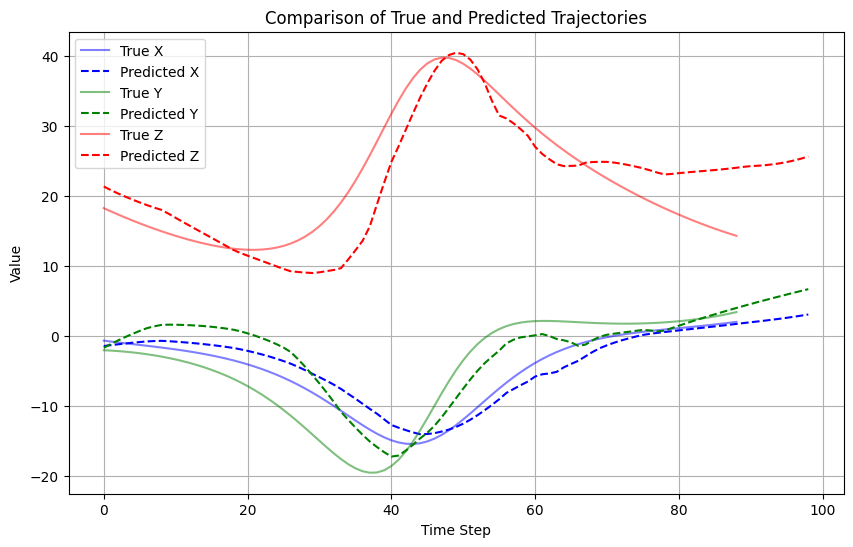

In [4]:
### Make predictions using the trained ML model
xVals = normalise(testVals[:-1], testVals[:-1].mean(axis=0),testVals[:-1].std(axis=0))
yVals = normalise(testVals[1:],testVals[1:].mean(axis=0),testVals[1:].std(axis=0))
predicted_trajectory = denormalise(model.predict(xVals), testVals[:-1].mean(axis=0),testVals[:-1].std(axis=0))

### Plot results
x_values = np.arange(len(yVals)) # hch: Katy, shouldn't this be np.arange(len(yVals))?
updated_y = denormalise(yVals,testVals[1:].mean(axis=0),testVals[1:].std(axis=0) )
updated_y = updated_y[10:] # hch: Katy, use Nt_shift or Dt to be consistent with your variable declarations.
smallX = x_values[:-10]
plt.figure(figsize=(10, 6))
for i in range(3):
    plt.plot(smallX,updated_y[:, i], label=f'True {["X", "Y", "Z"][i]}', color=['blue', 'green', 'red'][i],alpha = 0.5)
    plt.plot(x_values, predicted_trajectory[:, i], label=f'Predicted {["X", "Y", "Z"][i]}', linestyle='--', color=['blue', 'green', 'red'][i])
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Comparison of True and Predicted Trajectories')
plt.legend()
plt.grid(True)

### TODO items

* It seems the L63 model is not allowed to spin up before collecting the training and validation datasets. Please revisit as this might impact the performance of the ML model.

* Current evaluation of ML performance is not autoregressive. We need to test how the ML model performs if it's applied recursively on its own output. In other words, suppose you start from initial condition $x_0$. Applying the ML model $f$ once will give you $x_1 = f(x_0)$. After that, we will apply the ML model again to get $x_2 = f(x_1)$, and so on. To implement this, you will need to introduce a for loop that iterates over time. At the moment, the ML performance is only evaluated on one-step-ahead predictions by feeding multiple inputs (xVals).  